In [7]:
from tensorflow import keras

from tensorflow.keras import models, layers
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 

In [8]:
# Preparing the dataset and creating the features and target arrays


pd.set_option('mode.chained_assignment', None)

n_sims = 10000
n_list = [i for i in range(n_sims)]


h0s = []
results = []


start = 0
end = 10000

x = []
y =[]

for i in n_list[start:end]:
	
	data = np.load(f'input/data_{i+1}.npy')
	x.append(data[:, :2])
	y.append(data[:, 2:][0][0])
	print(f'Status: {((i+1)/end * 100):.2f} %', end='\r')


x = np.array(x)
# x[:,:,0] /= x[:,:,0].max()


y = np.array(y)

norm = y.max()


y /= norm


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

In [67]:
# defining the model

model = models.Sequential()

model.add(layers.Flatten())
model.add(layers.Dense(16))

model.add(layers.Dense(16))
model.add(layers.Dense(1))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=keras.metrics.MeanAbsoluteError())


model.fit(x_train, y_train, epochs=25, batch_size=8, verbose=1)

Epoch 1/25
938/938 [==============================] - 3s 3ms/step - loss: 889.7810 - mean_absolute_error: 10.0020
Epoch 2/25
938/938 [==============================] - 3s 3ms/step - loss: 0.7941 - mean_absolute_error: 0.6810
Epoch 3/25
938/938 [==============================] - 3s 3ms/step - loss: 0.3287 - mean_absolute_error: 0.4603
Epoch 4/25
938/938 [==============================] - 3s 3ms/step - loss: 0.2958 - mean_absolute_error: 0.4366
Epoch 5/25
938/938 [==============================] - 3s 3ms/step - loss: 0.2851 - mean_absolute_error: 0.4272
Epoch 6/25
938/938 [==============================] - 3s 3ms/step - loss: 0.3889 - mean_absolute_error: 0.4907
Epoch 7/25
938/938 [==============================] - 3s 3ms/step - loss: 0.4650 - mean_absolute_error: 0.5374
Epoch 8/25
938/938 [==============================] - 3s 3ms/step - loss: 1.4317 - mean_absolute_error: 0.7244
Epoch 9/25
938/938 [==============================] - 3s 3ms/step - loss: 0.4603 - mean_absolute_error: 0.498

In [68]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)



79/79 [==============================] - 0s 1ms/step


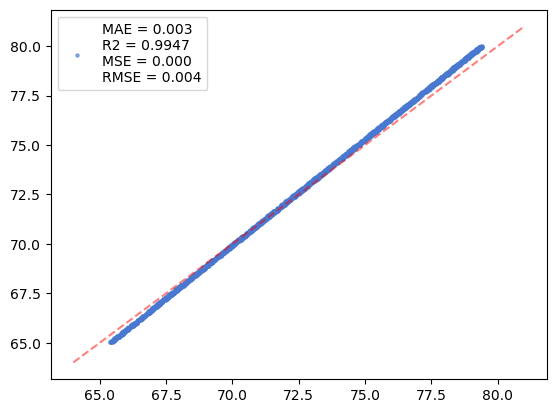

In [69]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.31, .315, 2500)


plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'MAE = {mae:.3f}\nR2 = {r2:.4f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()
plt.savefig("imagens/metrics_h0_dense")
plt.show()

In [70]:
# forecasting "real" H(0)

real = np.load('input/data_real80.npy')
real = real[real[:, 0].argsort()]

real = real.reshape(-1,80,2)

In [71]:

final_real = model.predict(real, verbose=0)

In [72]:
final_real*norm

array([[67.69018]], dtype=float32)

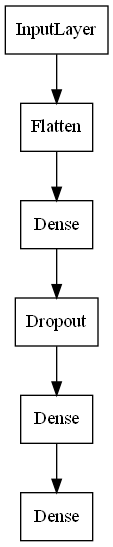

In [73]:
keras.utils.plot_model(model, to_file='imagens/model_dense.png', show_shapes=False, show_layer_names=False)
